In [ ]:
import matplotlib.pyplot as plt
import torchvision as tv
import torchvision
from torch.utils.data import DataLoader,Dataset
import torch
def get_loaders_MNIST(batch_size=100):
  transforms =tv.transforms.Compose([tv.transforms.ToTensor(),tv.transforms.Normalize((0.1307,), (0.3081,))])
  train_data = tv.datasets.MNIST( root="./data/",train=True,download=True,transform = transforms)
  test_data = tv.datasets.MNIST( root="./data/",train=False,download=True,transform = transforms)
  train_loader = DataLoader(train_data,batch_size=batch_size, shuffle=True,drop_last=True,num_workers=2)
  test_loader = DataLoader(dataset = test_data,batch_size = batch_size,shuffle = False)
  return train_loader, test_loader
def get_loaders_CIFAR10(batch_size=100):
  transform_train = tv.transforms.Compose([tv.transforms.RandomCrop(32, padding=4),tv.transforms.RandomHorizontalFlip(),tv.transforms.ToTensor(),tv.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994,0.2010)),])
  transform_test = tv.transforms.Compose([
  tv.transforms.ToTensor(),
  tv.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994,0.2010)),])
  trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,transform= transform_train)
  train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
  testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,transform=transform_test)
  test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)
  return train_loader, test_loader

In [ ]:
def decet(feature,targets,epoch,save_path):
  color = ["red", "black", "yellow", "green", "pink","gray", "lightgreen", "orange", "blue", "teal"]
  cls = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  plt.ion()
  plt.clf()
  for j in cls:
    mask = [targets == j]
    feature_ = feature[mask].numpy()
    x = feature_[:, 1]
    y = feature_[:, 0]
    label = cls
    plt.plot(x, y, ".", color=color[j])
    plt.legend(label, loc="upper right")
    plt.title("epoch={}".format(str(epoch+1)))
  plt.savefig('{}/{}.jpg'.format(save_path,epoch+1))
  plt.draw()
  plt.pause(0.01)

In [ ]:
import torch as t
import torch
import torch.nn as nn
import torch.nn.functional as F
class Network(nn.Module):
  def __init__(self, latent_dim):
    super().__init__()
    self.cnn_layers = nn.Sequential(
      #nn.Conv2d(1, 64, 3, 2, 1), # MNIST is gray scale, so input channels=1
 nn.Conv2d(3, 64, 3, 2, 1), # CIFAR-10 uses input channels=3 so
 # this line and comment above line
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64,256, 3, 2, 1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.Conv2d(256,256, 3, 1, 1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.Conv2d(256,64, 3, 1, 1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64,16,3, 2, 1),
      nn.ReLU())
    self.linear_layer = nn.Linear(16*4*4,latent_dim)
 #self.output_layer = nn.Linear(latent_dim,10,bias=False)
  def forward(self, xs):
    cnn_out = self.cnn_layers(xs)
    flatten = cnn_out.reshape(-1,16*4*4)
    latent_out = self.linear_layer(flatten)
 #output = self.output_layer(latent_out)
    return latent_out

In [ ]:
import torch.nn.functional as F
import torchvision as tv
import torch.nn as nn
import torch
class ArcNet(nn.Module):
  def __init__(self,num_classes,latent_dim,s=20,m=0.1): # orig, s=10,m=0.1
    super().__init__()
    self.s = s # scale
    self.m = torch.tensor(m) # margin
    self.w=nn.Parameter(torch.rand(latent_dim,num_classes)) #2*10

  def forward(self, embedding):
    embedding = F.normalize(embedding,dim=1) # normalize latent output
    w = F.normalize(self.w,dim=0) # normalize weights of ArcCos network
    cos_theta = torch.matmul(embedding, w)/self.s # /10
    sin_theta = torch.sqrt(1.0-torch.pow(cos_theta,2))
    cos_theta_m = cos_theta*torch.cos(self.m) - sin_theta*torch.sin(self.m)
    cos_theta_scaled = torch.exp(cos_theta * self.s)
    sum_cos_theta = torch.sum(torch.exp(cos_theta*self.s),dim=1,keepdim=True) -cos_theta_scaled
    top = torch.exp(cos_theta_m*self.s)
    arcout = (top/(top + sum_cos_theta))
    return arcout

In [ ]:
!pip3 install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=53d0b8d2f9f6f19b6fe0af6e409f39c977608c903ce4dda7551014375c568432
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


In [2]:
!pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=5722b26af780f64a547e4de21209a8c0b9481cef622d9b285bf805c8636736b1
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


In [3]:

import sys
import utils
import torch
import torch.nn as nn
import torch as t
def testdata_accuracy(CUDA, net, arcnet,test_loader):
  acc = 0
  for i, (x, y) in enumerate(test_loader):
    if CUDA:
      x = x.cuda()
      y = y.cuda()
    latent_out = net(x)
    arc_out = t.log(arcnet(latent_out))
 #---------test accuracy-----------------
    value = t.argmax(arc_out, dim=1)
    acc += t.sum((value == y).float())
  print('test accuracy = ', acc / len(y))

In [1]:
def main():
  latent_dim = 3 # embedding size
  num_classes = 10
  net = Network(latent_dim)
  #net = ResNet50(10, latent_dim, channels=3)
  CUDA = torch.cuda.is_available()
  if CUDA:
    net = net.cuda()

  arcnet = ArcNet(num_classes, latent_dim).cuda()
  arcloss = nn.NLLLoss(reduction="mean").cuda()
  optimizerarc = t.optim.SGD([{'params': net.parameters()}, {'params':arcnet.parameters()}], lr=0.01, momentum=0.9, weight_decay=0.0005)
  save_pic_path = "./data"
  train_loss = []
  test_loss = []
  train_accuracy = []
  test_accuracy = []
  num_epochs = 80

Files already downloaded and verified
Files already downloaded and verified


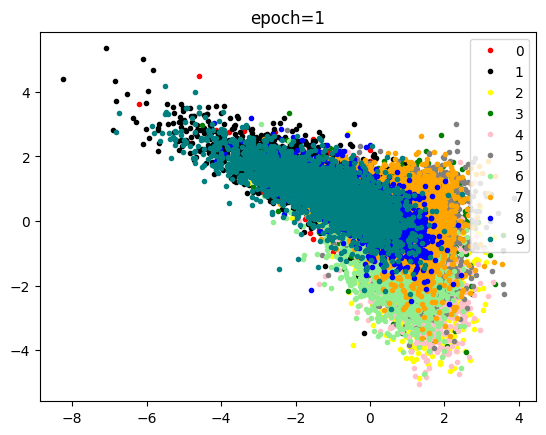

Epoch 1/80, Training Loss: 0.007, Training Accuracy: 0.430
test accuracy =  tensor(34.6400, device='cuda:0')


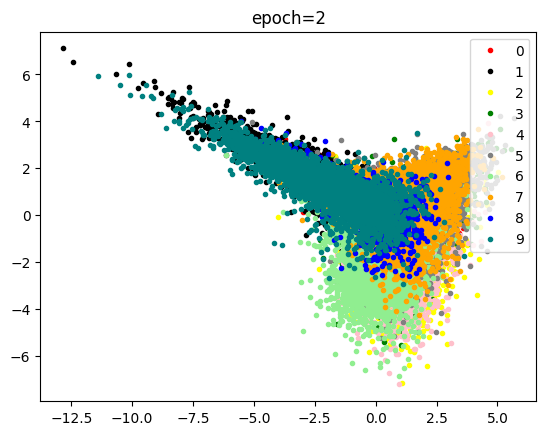

Epoch 2/80, Training Loss: 0.007, Training Accuracy: 0.320
test accuracy =  tensor(39.2400, device='cuda:0')


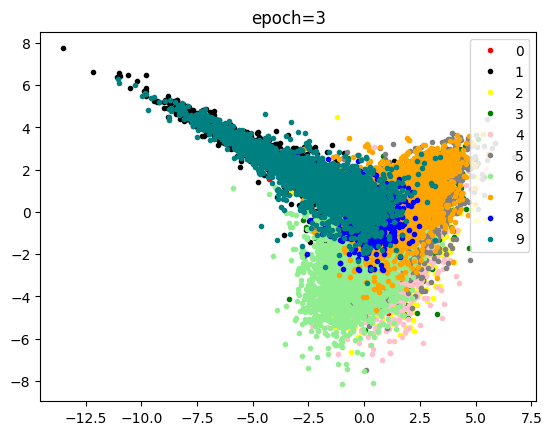

Epoch 3/80, Training Loss: 0.007, Training Accuracy: 0.500
test accuracy =  tensor(43.6500, device='cuda:0')


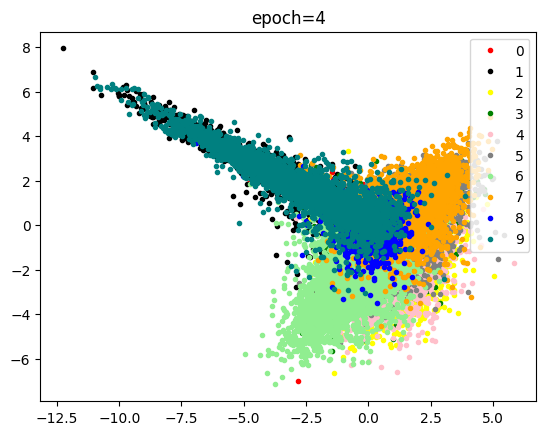

Epoch 4/80, Training Loss: 0.007, Training Accuracy: 0.520
test accuracy =  tensor(44.8800, device='cuda:0')


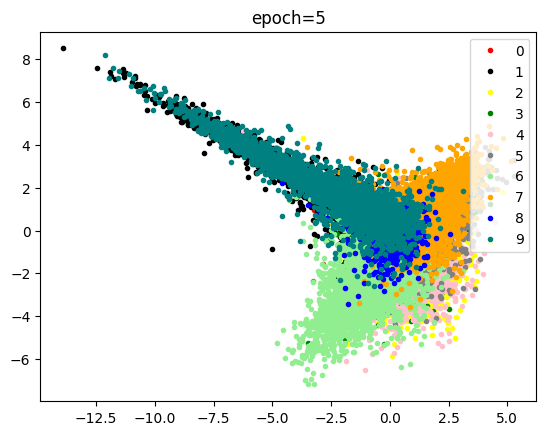

Epoch 5/80, Training Loss: 0.007, Training Accuracy: 0.490
test accuracy =  tensor(44.2300, device='cuda:0')


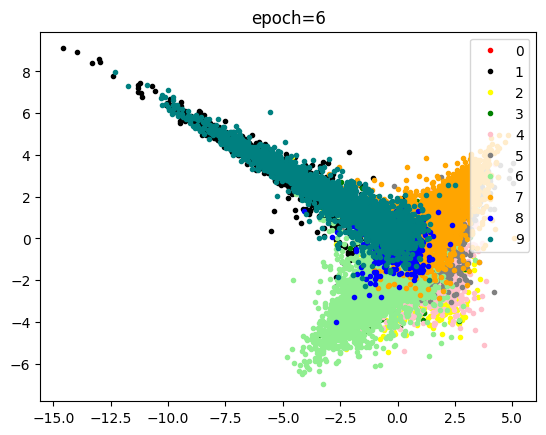

Epoch 6/80, Training Loss: 0.007, Training Accuracy: 0.560
test accuracy =  tensor(48.9100, device='cuda:0')


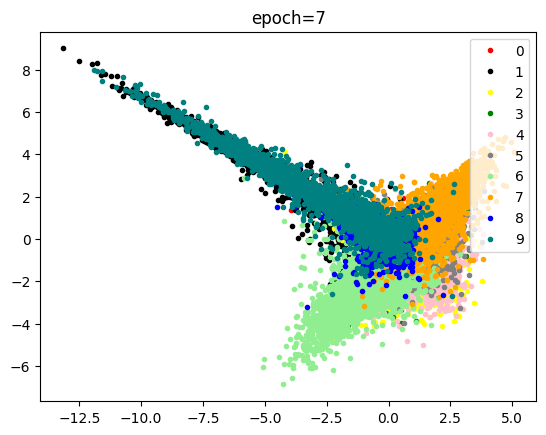

Epoch 7/80, Training Loss: 0.007, Training Accuracy: 0.510
test accuracy =  tensor(49.6000, device='cuda:0')


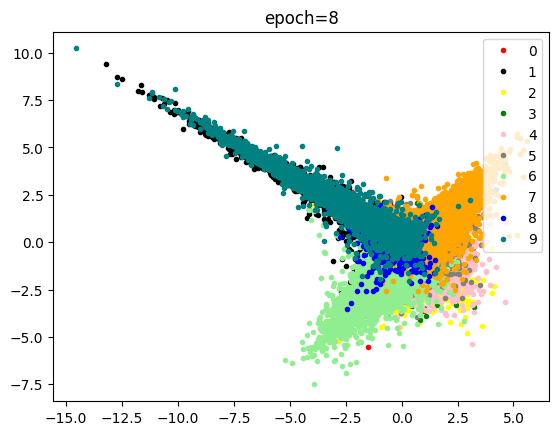

Epoch 8/80, Training Loss: 0.007, Training Accuracy: 0.530
test accuracy =  tensor(51.9200, device='cuda:0')


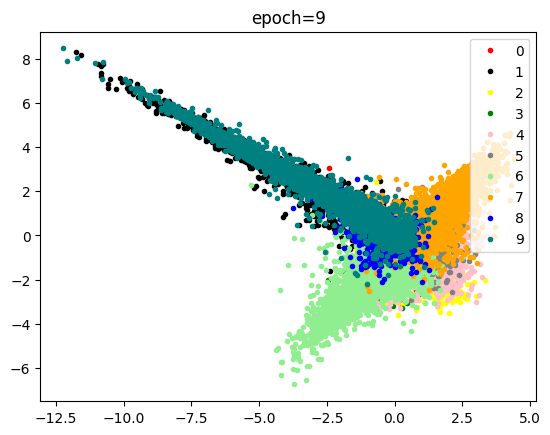

Epoch 9/80, Training Loss: 0.007, Training Accuracy: 0.540
test accuracy =  tensor(51.9200, device='cuda:0')


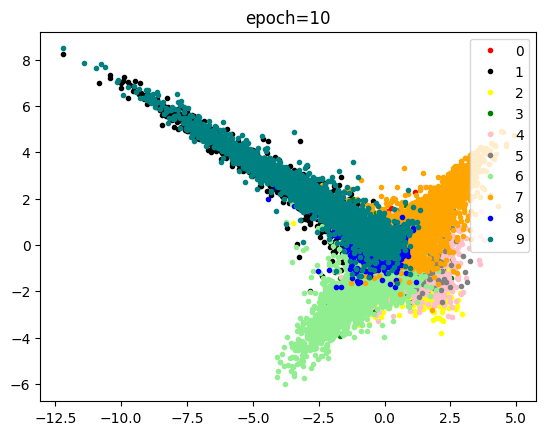

Epoch 10/80, Training Loss: 0.007, Training Accuracy: 0.530
test accuracy =  tensor(50.2500, device='cuda:0')


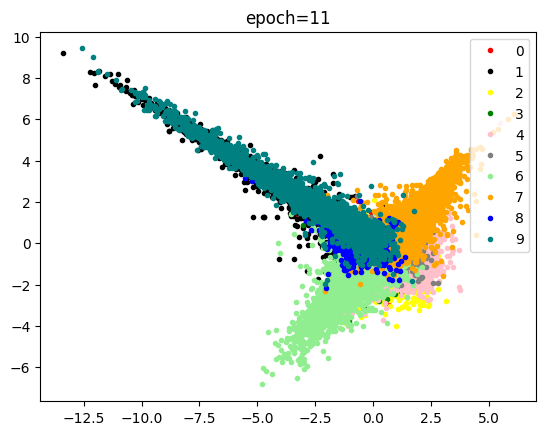

Epoch 11/80, Training Loss: 0.007, Training Accuracy: 0.520
test accuracy =  tensor(53.8500, device='cuda:0')


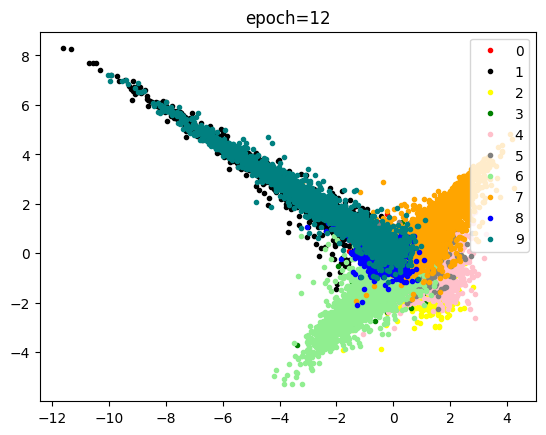

Epoch 12/80, Training Loss: 0.007, Training Accuracy: 0.580
test accuracy =  tensor(53.5200, device='cuda:0')


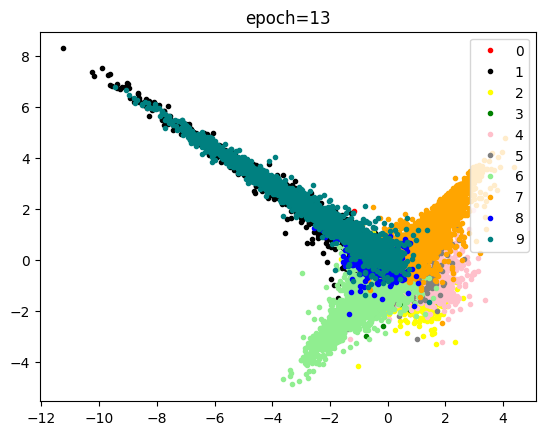

Epoch 13/80, Training Loss: 0.007, Training Accuracy: 0.600
test accuracy =  tensor(55.4900, device='cuda:0')


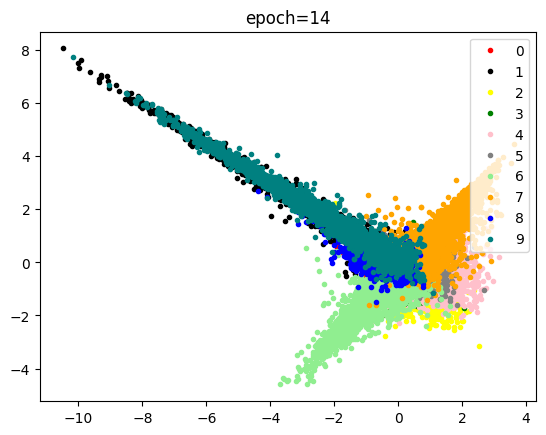

Epoch 14/80, Training Loss: 0.007, Training Accuracy: 0.570
test accuracy =  tensor(51.1900, device='cuda:0')


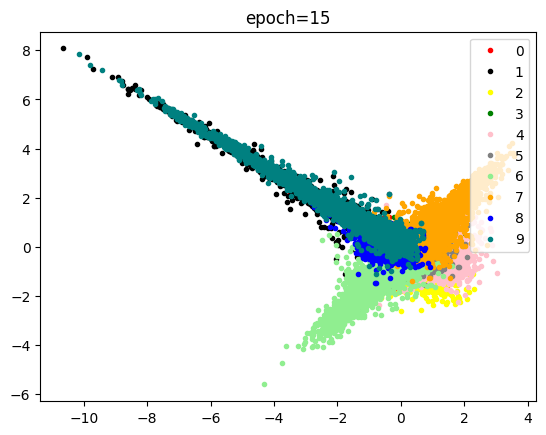

Epoch 15/80, Training Loss: 0.007, Training Accuracy: 0.550
test accuracy =  tensor(54.2600, device='cuda:0')


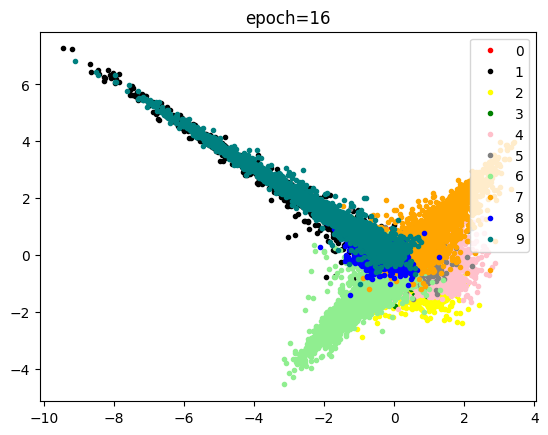

Epoch 16/80, Training Loss: 0.007, Training Accuracy: 0.540
test accuracy =  tensor(57.0600, device='cuda:0')


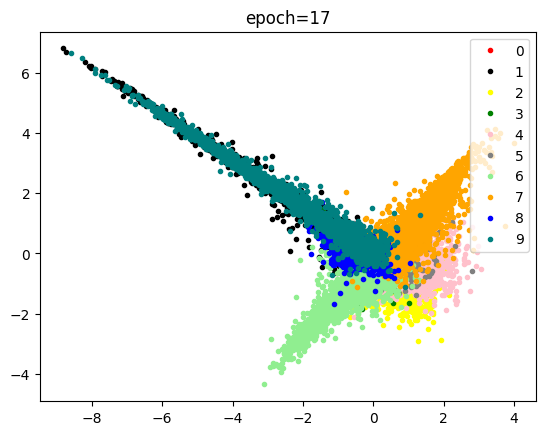

Epoch 17/80, Training Loss: 0.007, Training Accuracy: 0.610
test accuracy =  tensor(56.1200, device='cuda:0')


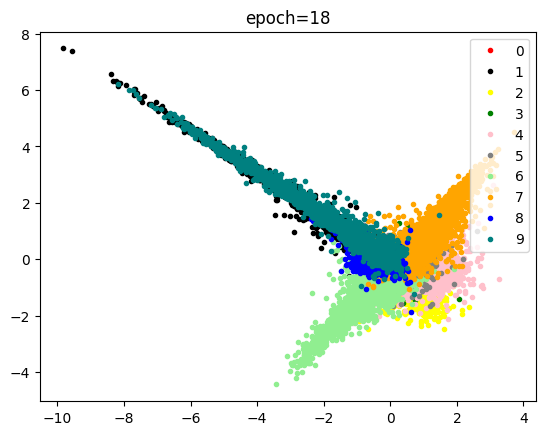

Epoch 18/80, Training Loss: 0.007, Training Accuracy: 0.730
test accuracy =  tensor(56.3200, device='cuda:0')


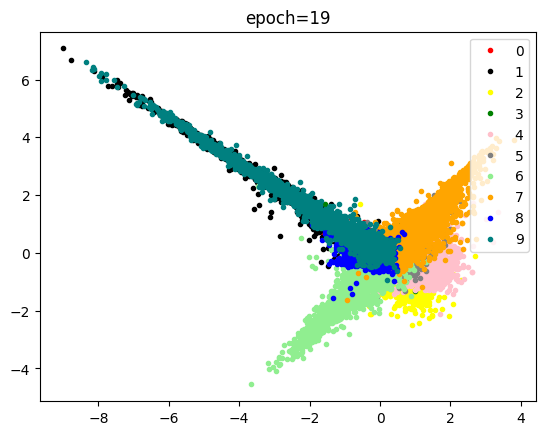

Epoch 19/80, Training Loss: 0.007, Training Accuracy: 0.630
test accuracy =  tensor(57.3500, device='cuda:0')


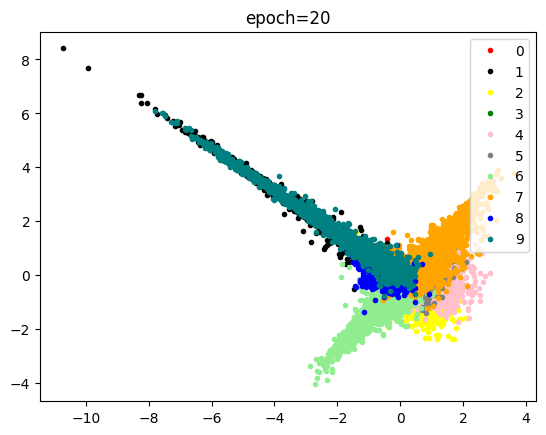

Epoch 20/80, Training Loss: 0.007, Training Accuracy: 0.620
test accuracy =  tensor(58.0100, device='cuda:0')


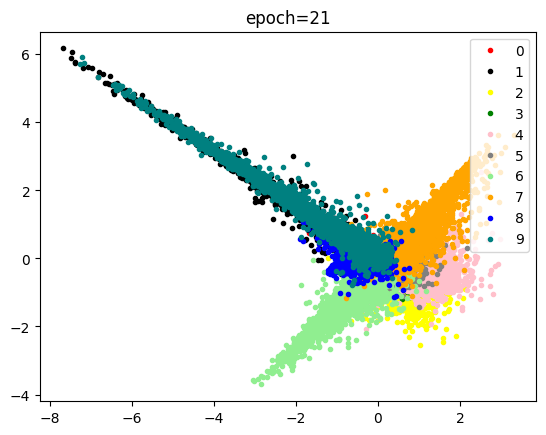

Epoch 21/80, Training Loss: 0.007, Training Accuracy: 0.630
test accuracy =  tensor(57.2400, device='cuda:0')


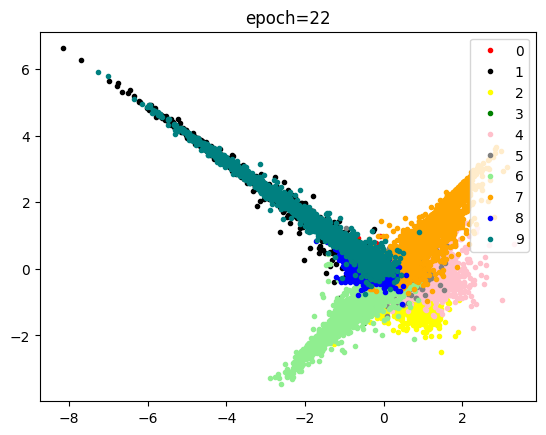

Epoch 22/80, Training Loss: 0.007, Training Accuracy: 0.700
test accuracy =  tensor(59.1600, device='cuda:0')


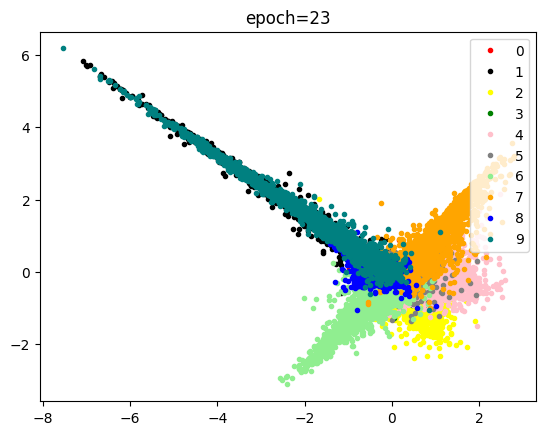

Epoch 23/80, Training Loss: 0.007, Training Accuracy: 0.620
test accuracy =  tensor(59.9100, device='cuda:0')


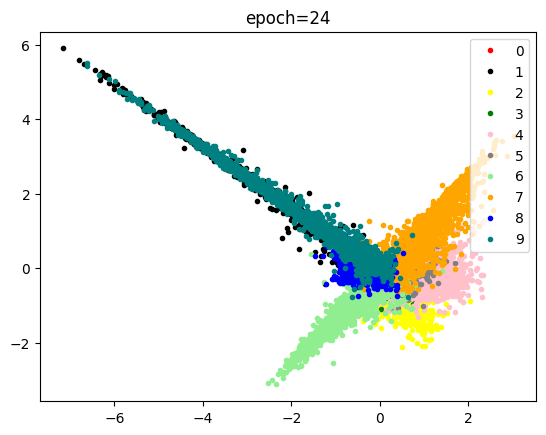

Epoch 24/80, Training Loss: 0.007, Training Accuracy: 0.600
test accuracy =  tensor(60.9900, device='cuda:0')


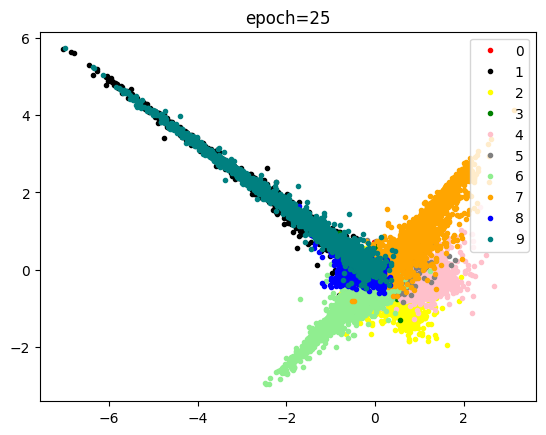

Epoch 25/80, Training Loss: 0.007, Training Accuracy: 0.730
test accuracy =  tensor(59.7300, device='cuda:0')


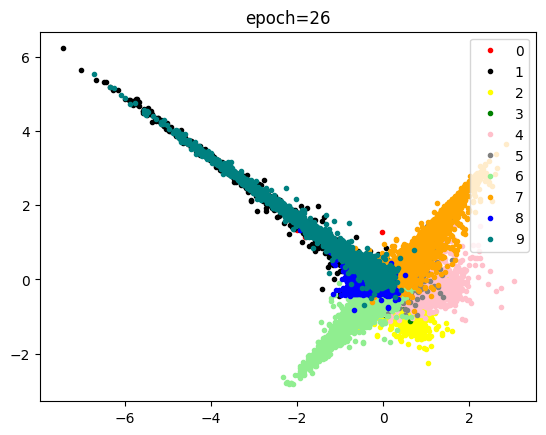

Epoch 26/80, Training Loss: 0.007, Training Accuracy: 0.680
test accuracy =  tensor(59.1600, device='cuda:0')


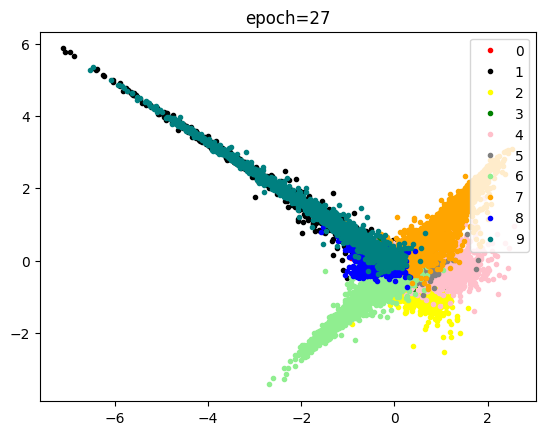

Epoch 27/80, Training Loss: 0.007, Training Accuracy: 0.710
test accuracy =  tensor(59.9600, device='cuda:0')


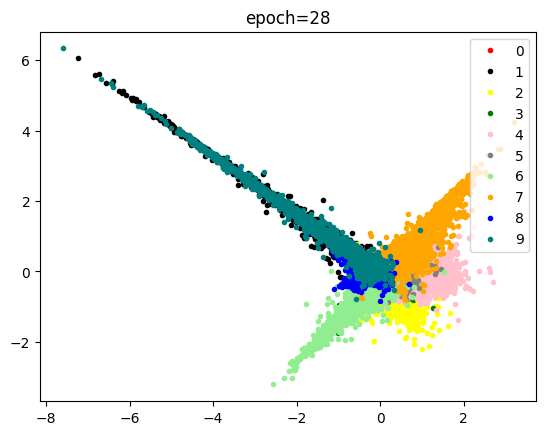

Epoch 28/80, Training Loss: 0.007, Training Accuracy: 0.630
test accuracy =  tensor(59.9000, device='cuda:0')


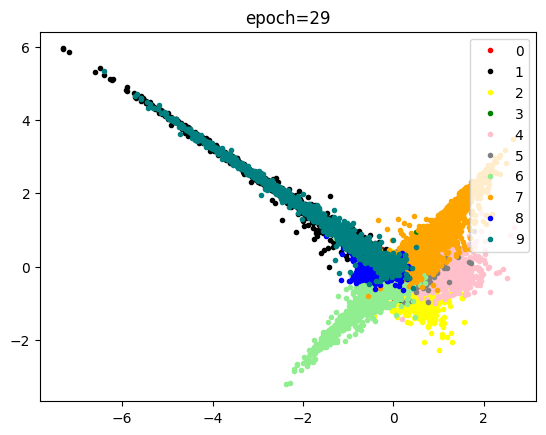

Epoch 29/80, Training Loss: 0.007, Training Accuracy: 0.650
test accuracy =  tensor(58.9200, device='cuda:0')


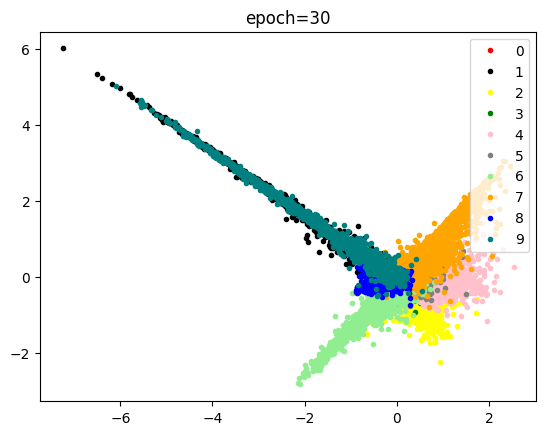

Epoch 30/80, Training Loss: 0.007, Training Accuracy: 0.750
test accuracy =  tensor(59.7400, device='cuda:0')


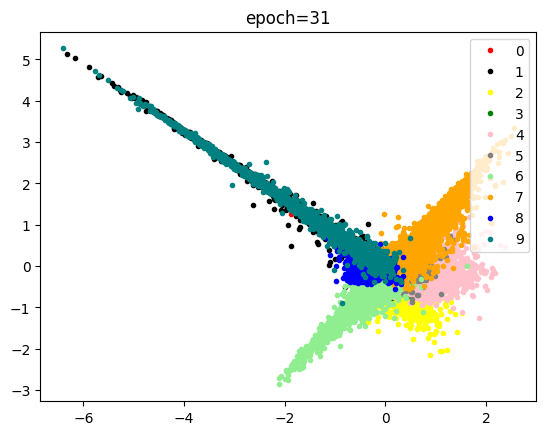

Epoch 31/80, Training Loss: 0.007, Training Accuracy: 0.620
test accuracy =  tensor(60.4600, device='cuda:0')


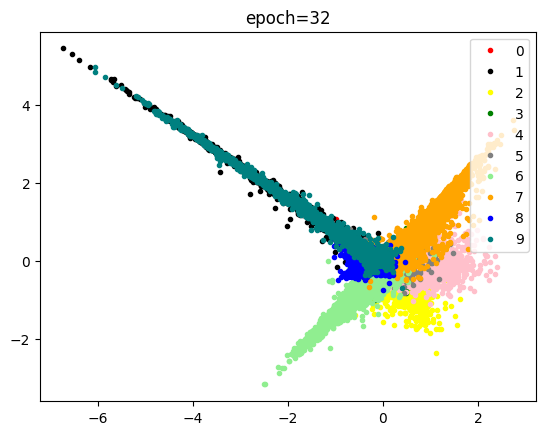

Epoch 32/80, Training Loss: 0.007, Training Accuracy: 0.670
test accuracy =  tensor(61.6900, device='cuda:0')


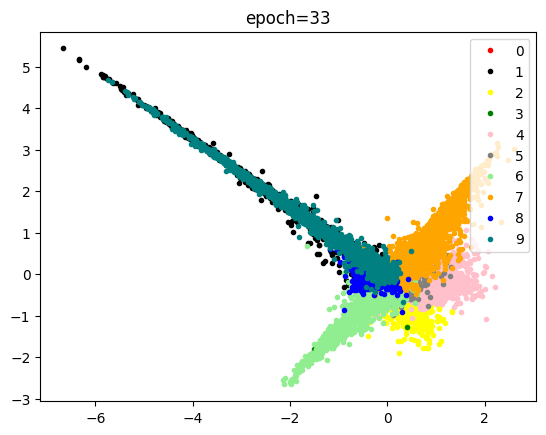

Epoch 33/80, Training Loss: 0.007, Training Accuracy: 0.610
test accuracy =  tensor(61.5300, device='cuda:0')


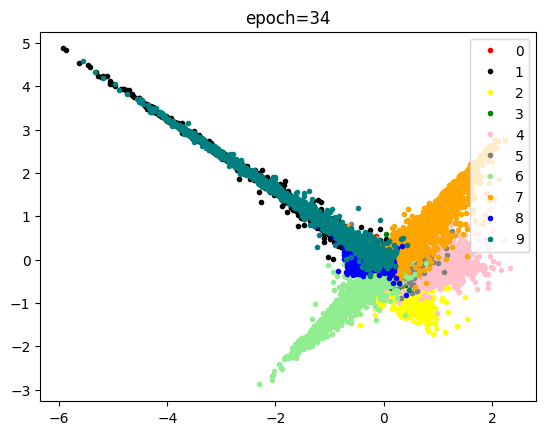

Epoch 34/80, Training Loss: 0.007, Training Accuracy: 0.630
test accuracy =  tensor(60.7400, device='cuda:0')


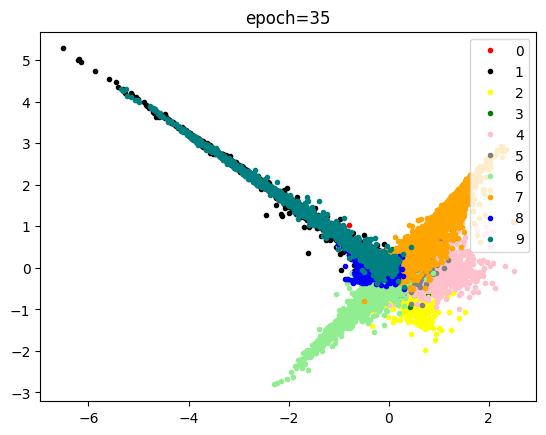

Epoch 35/80, Training Loss: 0.007, Training Accuracy: 0.660
test accuracy =  tensor(61.3200, device='cuda:0')


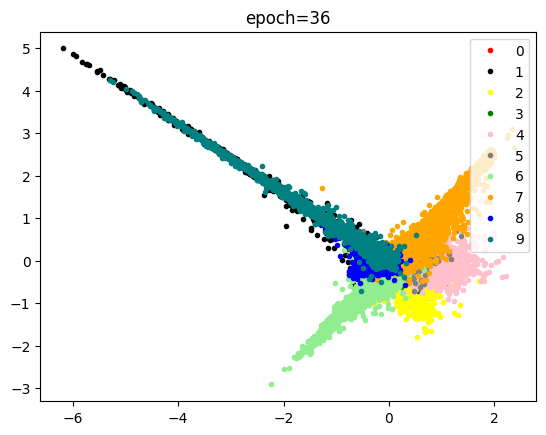

Epoch 36/80, Training Loss: 0.007, Training Accuracy: 0.690
test accuracy =  tensor(60.7200, device='cuda:0')


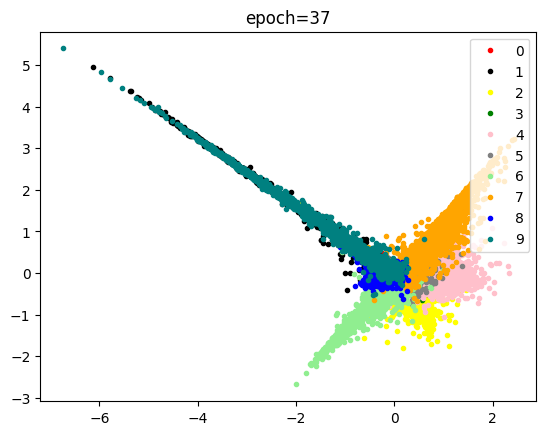

Epoch 37/80, Training Loss: 0.007, Training Accuracy: 0.770
test accuracy =  tensor(60., device='cuda:0')


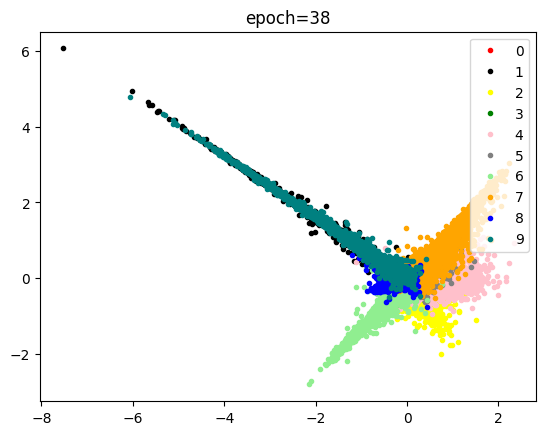

Epoch 38/80, Training Loss: 0.007, Training Accuracy: 0.610
test accuracy =  tensor(59.3900, device='cuda:0')


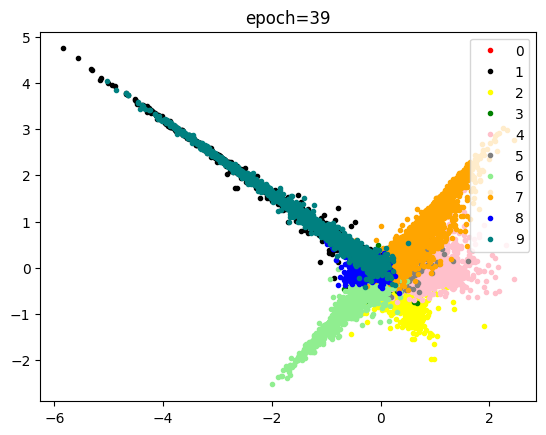

Epoch 39/80, Training Loss: 0.007, Training Accuracy: 0.680
test accuracy =  tensor(61.3900, device='cuda:0')


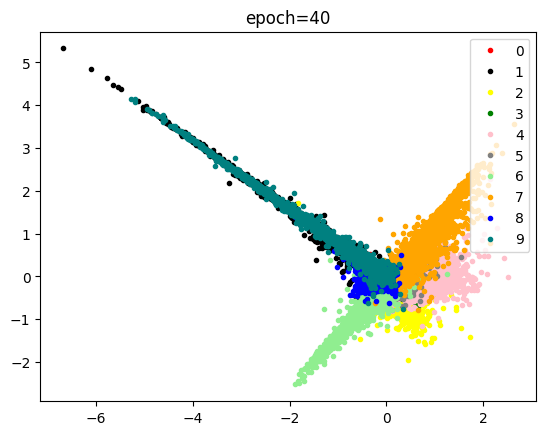

Epoch 40/80, Training Loss: 0.007, Training Accuracy: 0.670
test accuracy =  tensor(60.4700, device='cuda:0')


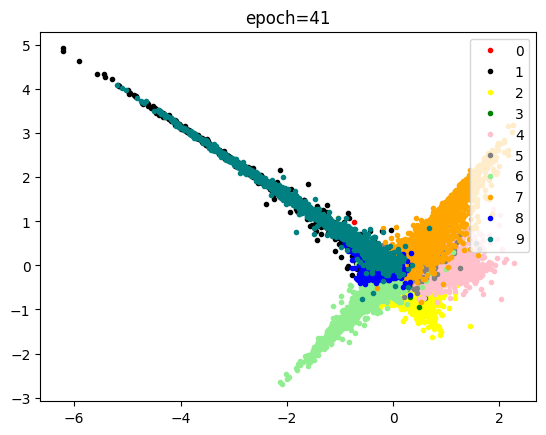

Epoch 41/80, Training Loss: 0.007, Training Accuracy: 0.620
test accuracy =  tensor(61.2300, device='cuda:0')


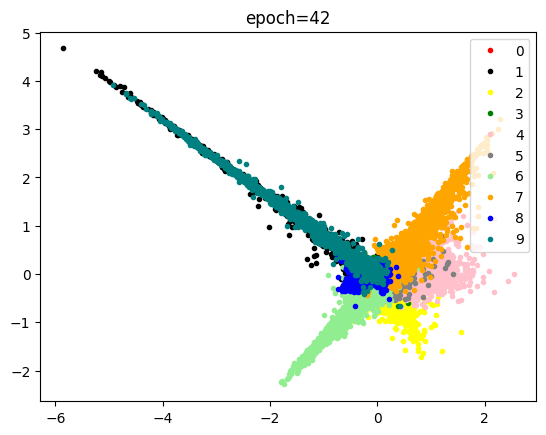

Epoch 42/80, Training Loss: 0.007, Training Accuracy: 0.660
test accuracy =  tensor(61.9200, device='cuda:0')


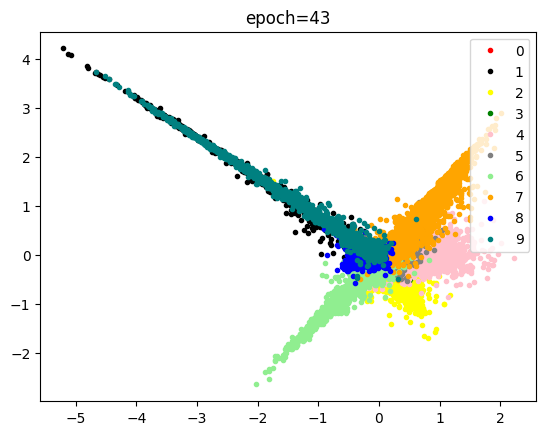

Epoch 43/80, Training Loss: 0.007, Training Accuracy: 0.740
test accuracy =  tensor(62.2700, device='cuda:0')


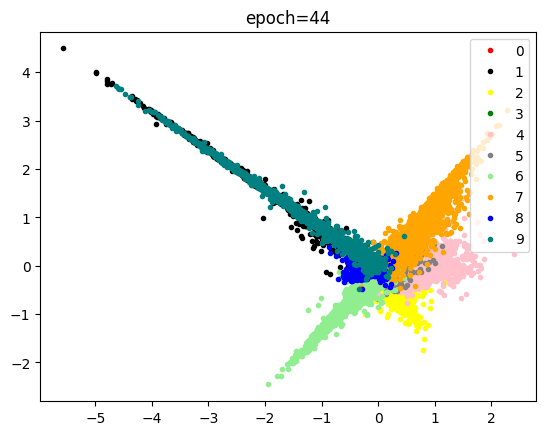

Epoch 44/80, Training Loss: 0.007, Training Accuracy: 0.660
test accuracy =  tensor(61.6600, device='cuda:0')


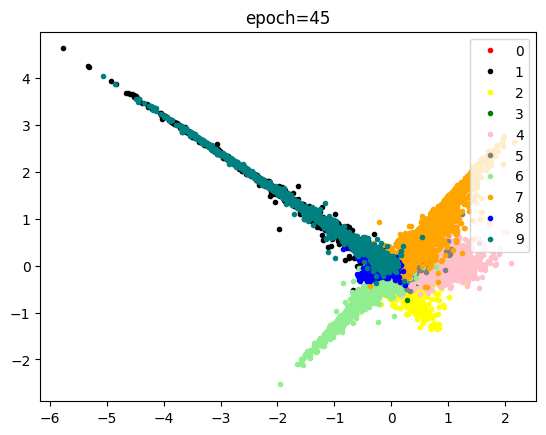

Epoch 45/80, Training Loss: 0.007, Training Accuracy: 0.690
test accuracy =  tensor(61.8600, device='cuda:0')


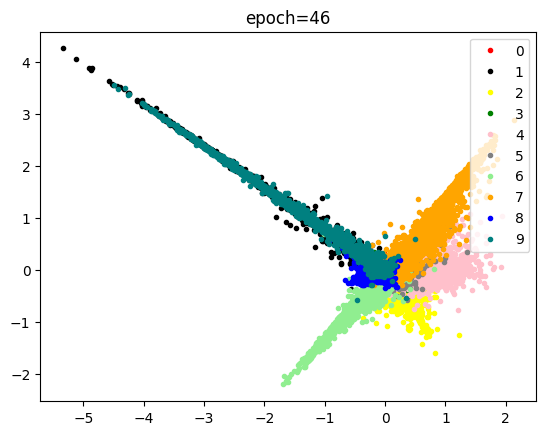

Epoch 46/80, Training Loss: 0.007, Training Accuracy: 0.760
test accuracy =  tensor(63.6400, device='cuda:0')


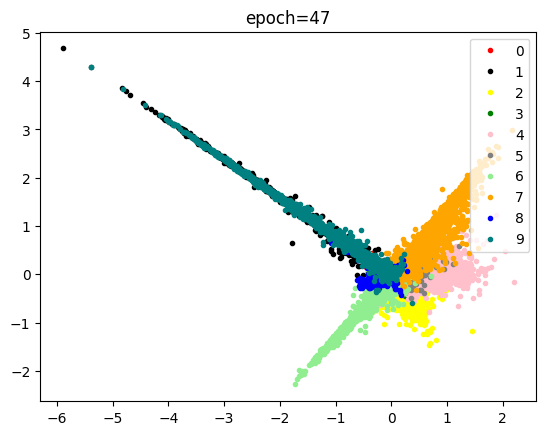

Epoch 47/80, Training Loss: 0.007, Training Accuracy: 0.770
test accuracy =  tensor(61.9100, device='cuda:0')


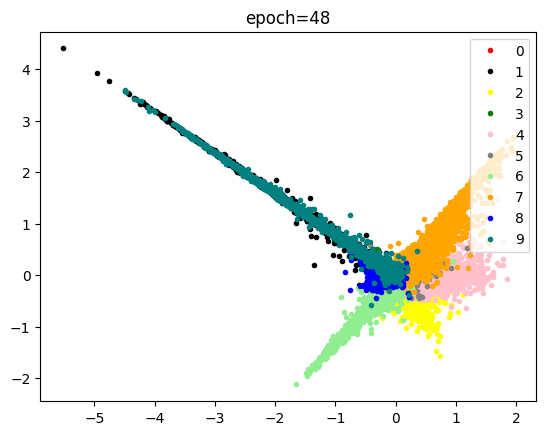

Epoch 48/80, Training Loss: 0.007, Training Accuracy: 0.690
test accuracy =  tensor(61.9100, device='cuda:0')


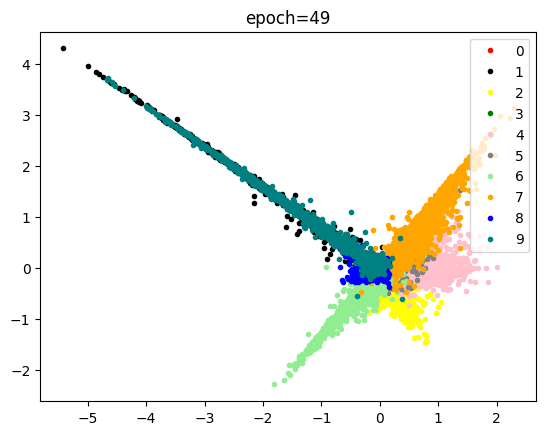

Epoch 49/80, Training Loss: 0.007, Training Accuracy: 0.690
test accuracy =  tensor(63.6000, device='cuda:0')


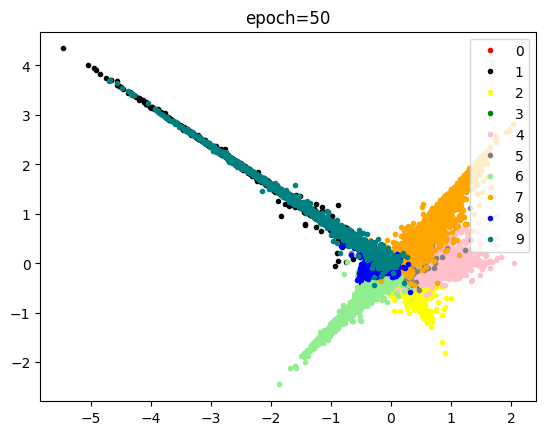

Epoch 50/80, Training Loss: 0.007, Training Accuracy: 0.750
test accuracy =  tensor(63., device='cuda:0')


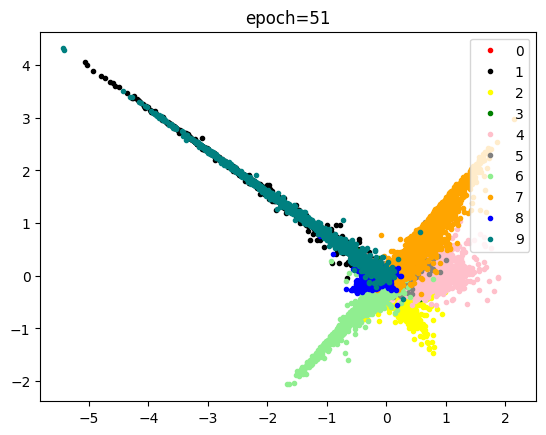

Epoch 51/80, Training Loss: 0.007, Training Accuracy: 0.720
test accuracy =  tensor(61.8600, device='cuda:0')


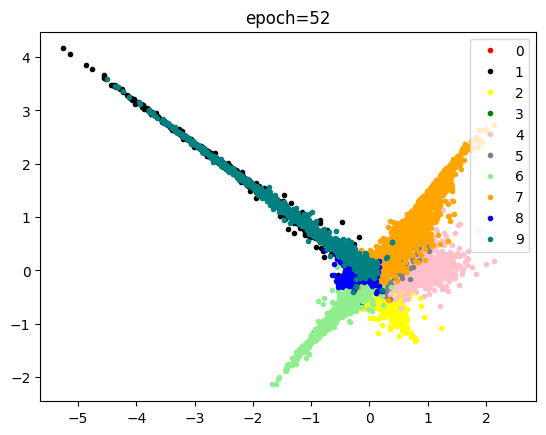

Epoch 52/80, Training Loss: 0.007, Training Accuracy: 0.700
test accuracy =  tensor(63.4800, device='cuda:0')


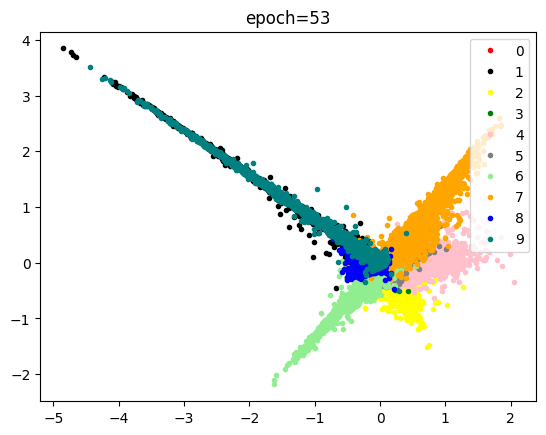

Epoch 53/80, Training Loss: 0.007, Training Accuracy: 0.710
test accuracy =  tensor(62.5900, device='cuda:0')


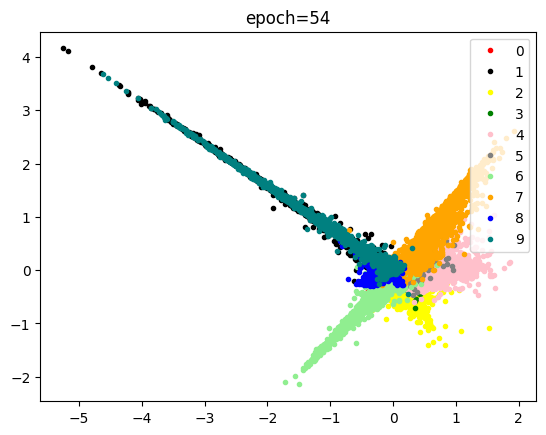

Epoch 54/80, Training Loss: 0.007, Training Accuracy: 0.720
test accuracy =  tensor(62.3900, device='cuda:0')


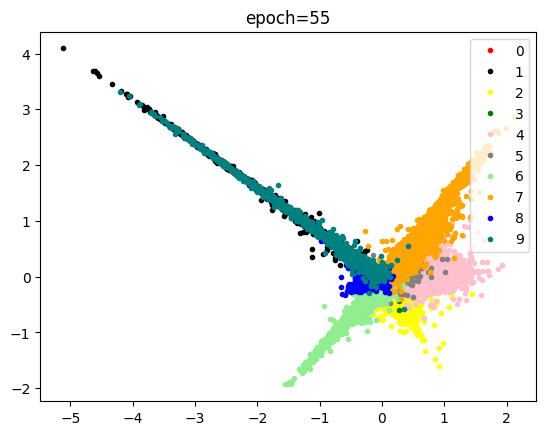

Epoch 55/80, Training Loss: 0.007, Training Accuracy: 0.640
test accuracy =  tensor(60.7400, device='cuda:0')


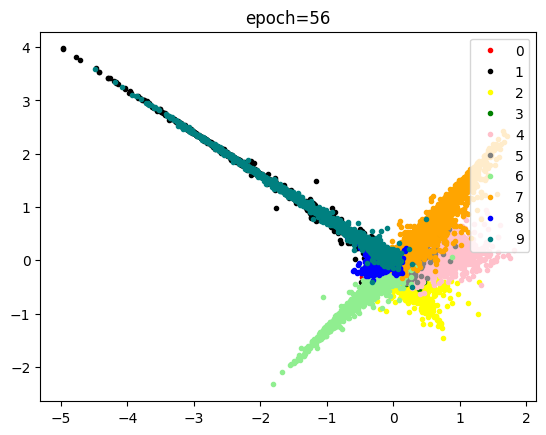

Epoch 56/80, Training Loss: 0.007, Training Accuracy: 0.650
test accuracy =  tensor(63.2800, device='cuda:0')


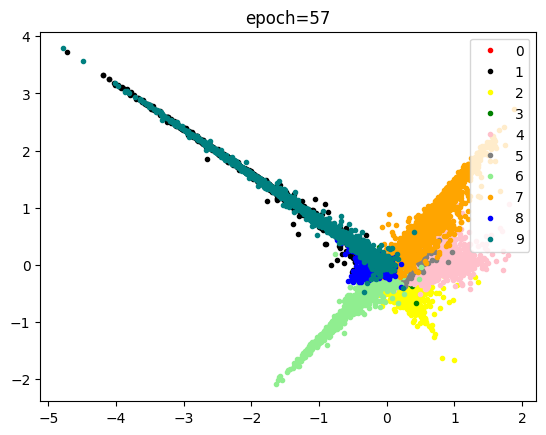

Epoch 57/80, Training Loss: 0.007, Training Accuracy: 0.670
test accuracy =  tensor(63.4200, device='cuda:0')


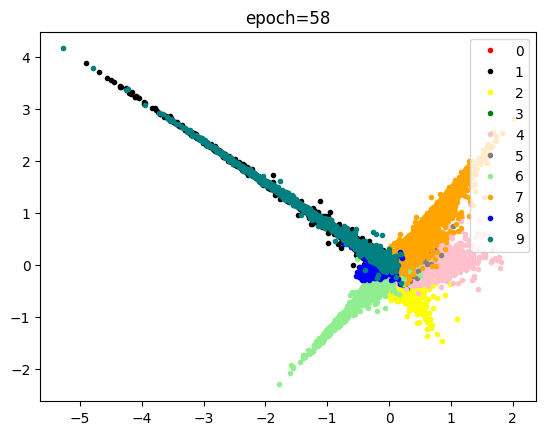

Epoch 58/80, Training Loss: 0.007, Training Accuracy: 0.730
test accuracy =  tensor(63.8300, device='cuda:0')


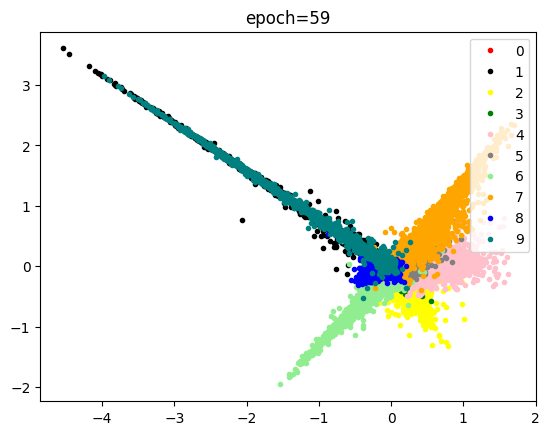

Epoch 59/80, Training Loss: 0.007, Training Accuracy: 0.650
test accuracy =  tensor(63.4100, device='cuda:0')


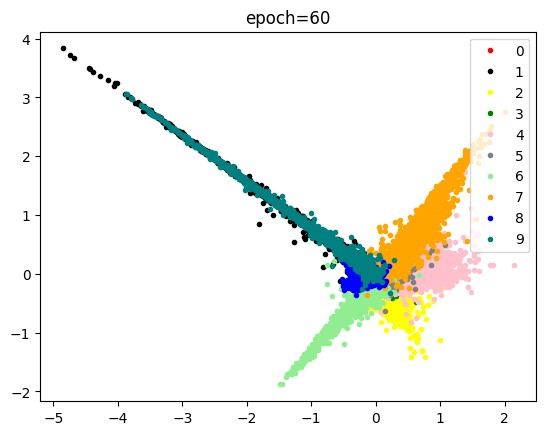

Epoch 60/80, Training Loss: 0.007, Training Accuracy: 0.670
test accuracy =  tensor(62.8000, device='cuda:0')


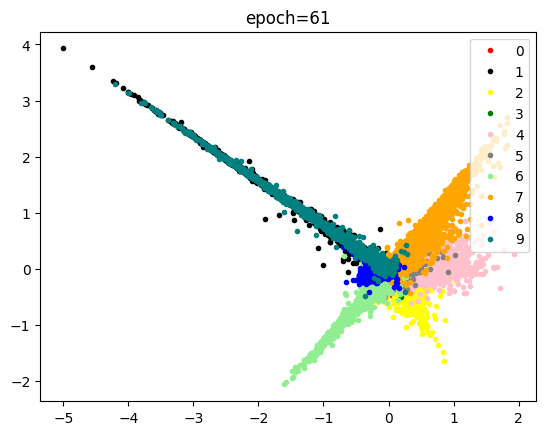

Epoch 61/80, Training Loss: 0.007, Training Accuracy: 0.780
test accuracy =  tensor(63.6000, device='cuda:0')


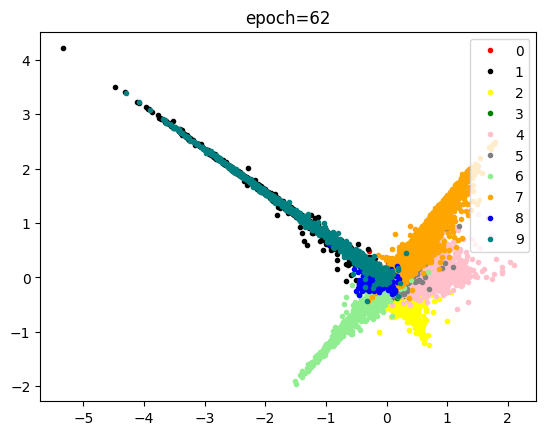

Epoch 62/80, Training Loss: 0.007, Training Accuracy: 0.750
test accuracy =  tensor(63.7000, device='cuda:0')


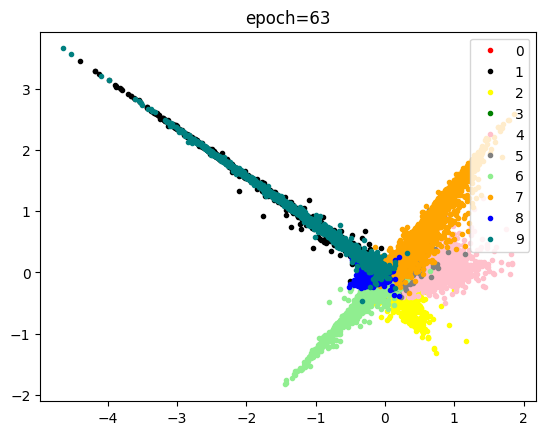

Epoch 63/80, Training Loss: 0.007, Training Accuracy: 0.750
test accuracy =  tensor(64.7400, device='cuda:0')


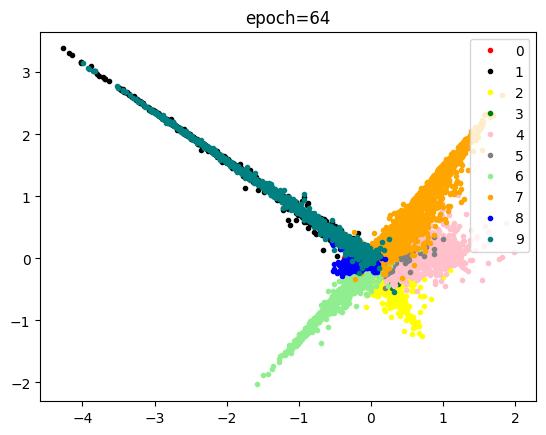

Epoch 64/80, Training Loss: 0.007, Training Accuracy: 0.820
test accuracy =  tensor(63.2600, device='cuda:0')


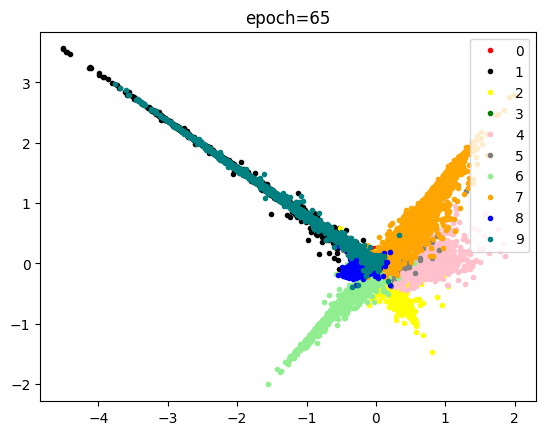

Epoch 65/80, Training Loss: 0.007, Training Accuracy: 0.750
test accuracy =  tensor(63.5500, device='cuda:0')


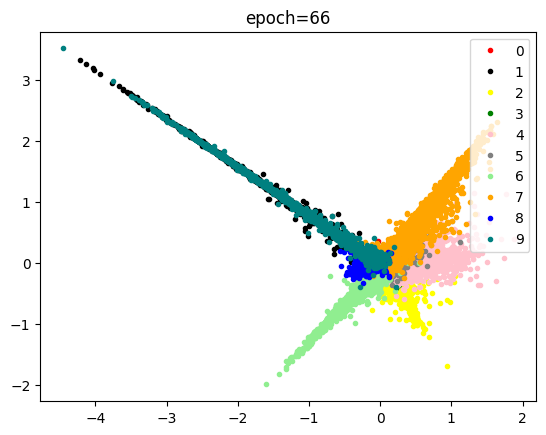

Epoch 66/80, Training Loss: 0.007, Training Accuracy: 0.730
test accuracy =  tensor(64.1200, device='cuda:0')


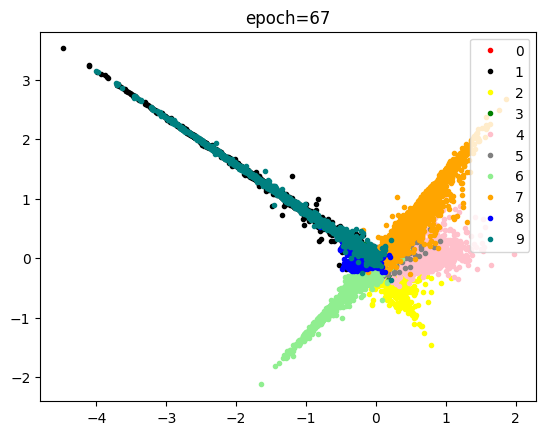

Epoch 67/80, Training Loss: 0.007, Training Accuracy: 0.770
test accuracy =  tensor(64.1300, device='cuda:0')


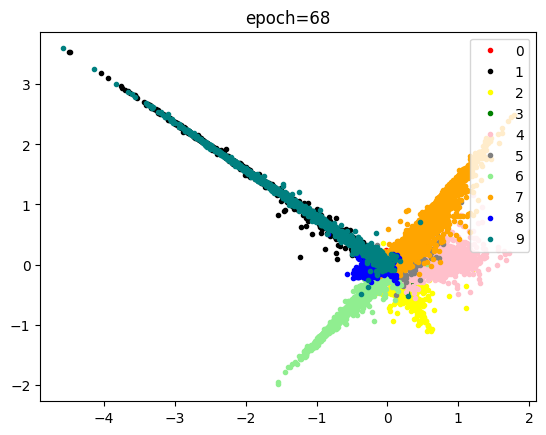

Epoch 68/80, Training Loss: 0.007, Training Accuracy: 0.660
test accuracy =  tensor(63.2900, device='cuda:0')


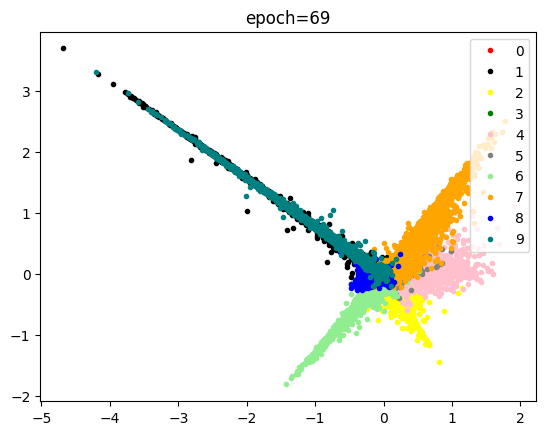

Epoch 69/80, Training Loss: 0.007, Training Accuracy: 0.720
test accuracy =  tensor(64.1800, device='cuda:0')


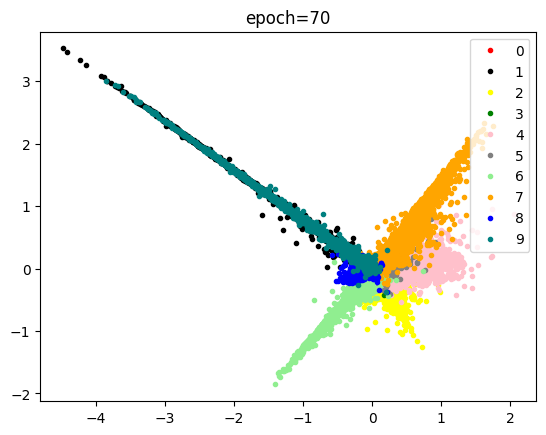

Epoch 70/80, Training Loss: 0.007, Training Accuracy: 0.800
test accuracy =  tensor(64.2700, device='cuda:0')


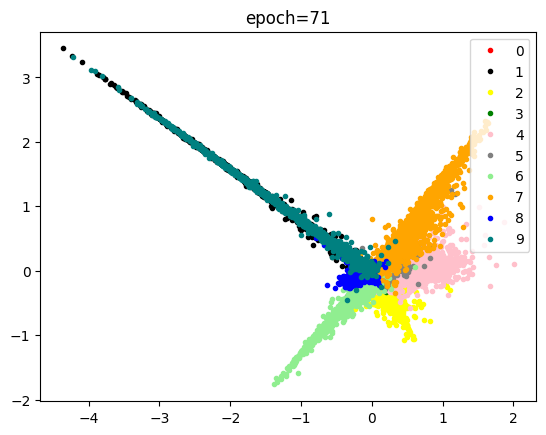

Epoch 71/80, Training Loss: 0.007, Training Accuracy: 0.780
test accuracy =  tensor(64.0500, device='cuda:0')


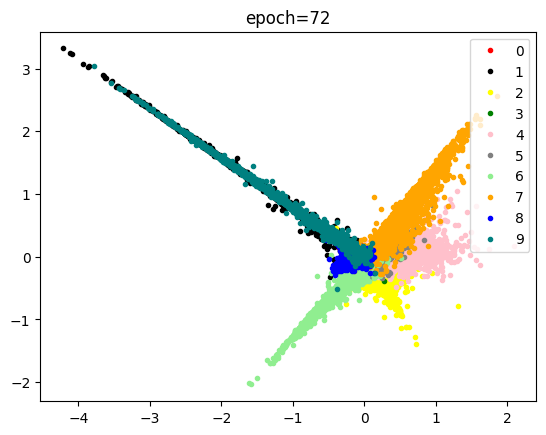

Epoch 72/80, Training Loss: 0.007, Training Accuracy: 0.720
test accuracy =  tensor(62.7400, device='cuda:0')


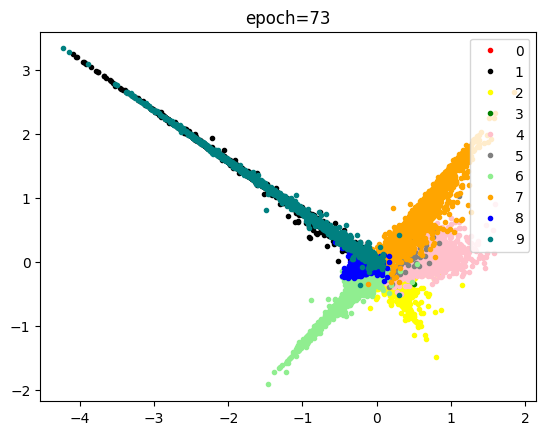

Epoch 73/80, Training Loss: 0.007, Training Accuracy: 0.680
test accuracy =  tensor(63.6400, device='cuda:0')


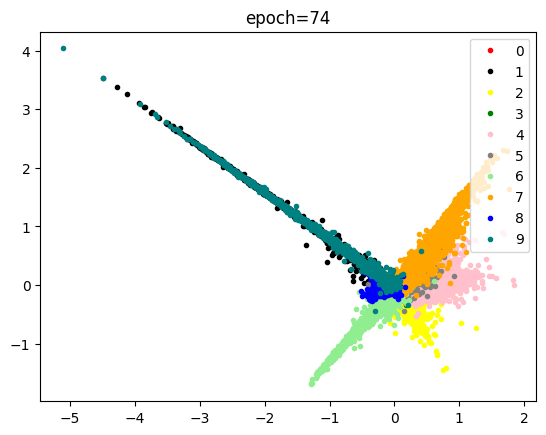

Epoch 74/80, Training Loss: 0.007, Training Accuracy: 0.710
test accuracy =  tensor(63.7700, device='cuda:0')


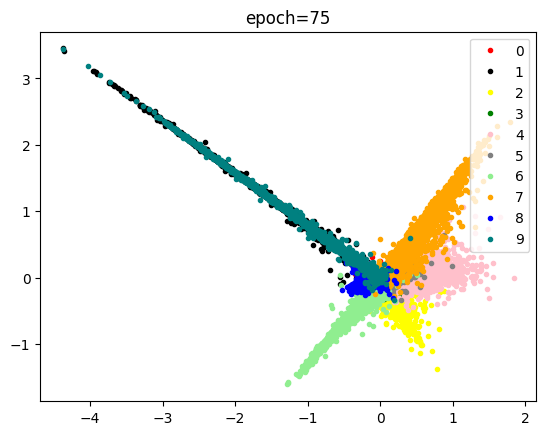

Epoch 75/80, Training Loss: 0.007, Training Accuracy: 0.710
test accuracy =  tensor(64.1400, device='cuda:0')


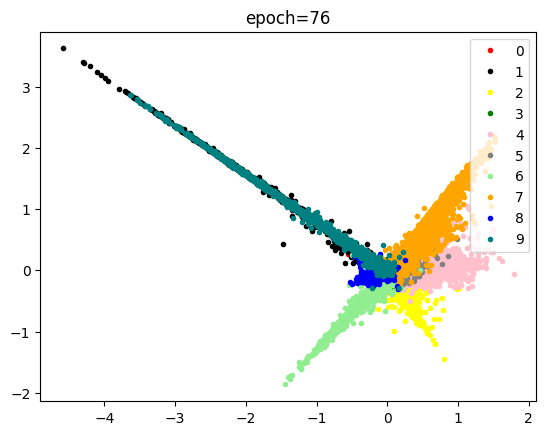

Epoch 76/80, Training Loss: 0.007, Training Accuracy: 0.650
test accuracy =  tensor(64.6700, device='cuda:0')


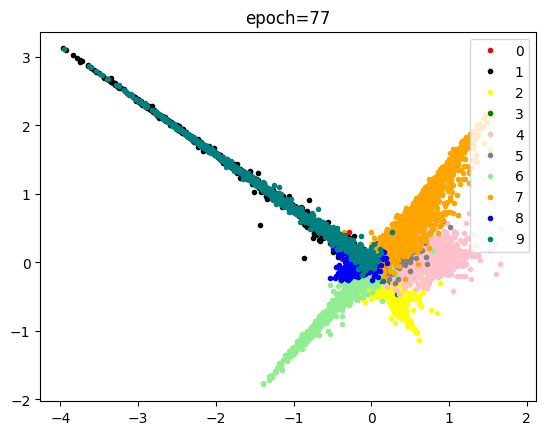

Epoch 77/80, Training Loss: 0.007, Training Accuracy: 0.730
test accuracy =  tensor(64.4600, device='cuda:0')


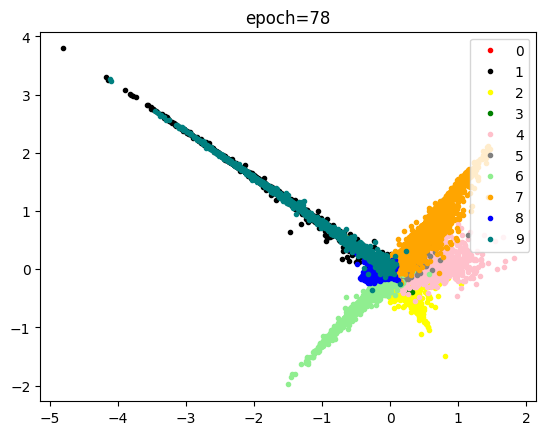

Epoch 78/80, Training Loss: 0.007, Training Accuracy: 0.750
test accuracy =  tensor(64.6600, device='cuda:0')


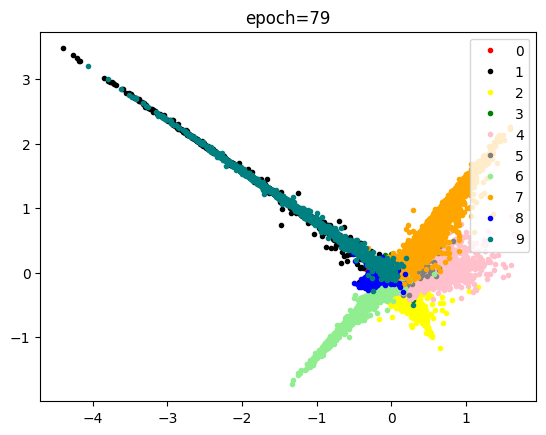

Epoch 79/80, Training Loss: 0.007, Training Accuracy: 0.720
test accuracy =  tensor(63.7200, device='cuda:0')


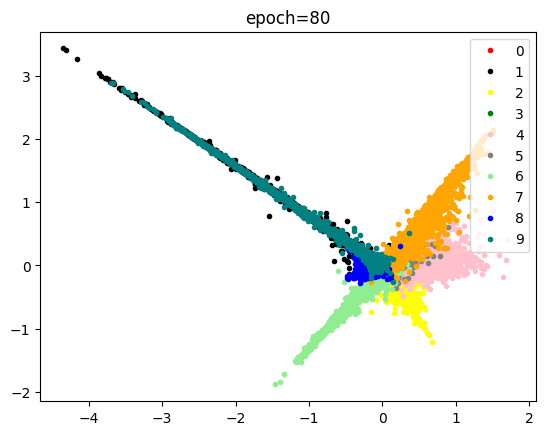

Epoch 80/80, Training Loss: 0.007, Training Accuracy: 0.690
test accuracy =  tensor(64.0200, device='cuda:0')


SystemExit: 0

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
import torch as t
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

def main():
  latent_dim = 3 # embedding size
  num_classes = 10
  net = Network(latent_dim)
  #net = ResNet50(10, latent_dim, channels=3)
  CUDA = torch.cuda.is_available()
  if CUDA:
    net = net.cuda()

  arcnet = ArcNet(num_classes, latent_dim).cuda()
  arcloss = nn.NLLLoss(reduction="mean").cuda()
  optimizerarc = t.optim.SGD([{'params': net.parameters()}, {'params':arcnet.parameters()}], lr=0.01, momentum=0.9, weight_decay=0.0005)
  save_pic_path = "./data"
  train_loss = []
  test_loss = []
  train_accuracy = []
  test_accuracy = []
  num_epochs = 80
  train_loader, test_loader = get_loaders_CIFAR10()
  #train_loader, test_loader = get_loaders_MNIST()
  for epoch in range(num_epochs):
    correct = 0
    iterations = 0
    iter_loss = 0.0
    feat = []
    target = []
    net.train()
    embedding = []
    target = []
    for i, (x, y) in enumerate(train_loader):
      if CUDA:
        x = x.cuda()
        y = y.cuda()
      latent_out = net(x)

 #-------------loss calculation--------------
      arc_out = t.log(arcnet(latent_out))
      arcface_loss = arcloss(arc_out, y)
      iter_loss = arcface_loss.item()
 #-------------compute accuracy-------------
      value = t.argmax(arc_out, dim=1)
      acc = t.sum((value == y).float()) / len(y)

 #----------compute gradients, update network parameters----
      optimizerarc.zero_grad()
      arcface_loss.backward()
      optimizerarc.step()

      embedding.append(latent_out)
      target.append(y)
      iterations += 1
      if epoch > 10:
        optimizerarc.param_groups[0]['lr'] = 0.005
      if epoch > 20:
        optimizerarc.param_groups[0]['lr'] = 0.002
      if epoch > 40:
        optimizerarc.param_groups[0]['lr'] = 0.001
      if epoch > 60:
        optimizerarc.param_groups[0]['lr'] = 0.0001
    features = t.cat(embedding, 0)
    targets = t.cat(target, 0)
    decet(features.data.cpu(), targets.data.cpu(),epoch,save_pic_path)
    train_loss.append(iter_loss/iterations)
    train_accuracy.append(acc)
    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}'.format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1]))
    testdata_accuracy(CUDA, net,arcnet, test_loader)

  PATH = "./data/model.pth"
  torch.save(net.state_dict(),PATH)
if __name__ == "__main__":
  sys.exit(int(main() or 0))